In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=2000, n_features=15, n_classes=2)
X.shape, y.shape

((2000, 15), (2000,))

In [3]:
# X = np.hstack([np.ones((1000, 1)), X]) # to add intercept

In [4]:
X.mean(axis=0), X.std(axis=0) # no need to standardize

(array([ 0.01591941,  0.01356525,  0.02494744,  0.00020762,  0.01050833,
         0.00616218, -0.01490469,  0.02166403,  0.02961345,  0.01968115,
        -0.01737201,  0.02163154, -0.05088175,  0.01878491, -0.02258619]),
 array([1.01027516, 0.99715042, 1.2175409 , 1.00852044, 1.20121197,
        0.96742793, 0.9913056 , 1.01978446, 1.27241581, 0.98808174,
        0.98493146, 1.01879564, 1.01522904, 0.99458642, 0.91545871]))

## My Logistic Regression Class realization

### Features to add:
- <b>Different types of gradient descent (GD) </b>
    - Full GD (already implemented)
    - stochastic GD (SGD) one random object used to find gradient
    - stochastic average SAGD (several random objects used to find gradient)
    
- <b>Different loss functions </b>
    - Logloss (already implemented)
    - MSE :) for fun
- <b>Info about model </b>
    - Coefficients, intercept, parameters set (learning rate, regularization)
    - Stats (p-values, confidence intervals, model adequacy)
    - Quality metrics w
- <b> Marginal Effects (ME) </b>
        - ME for each factor (done)
        - ME at means, median, at any factors given
        - average ME (AME) for each factor
- <b> Non-linear factors </b>
        - ME for them also

In [5]:
class Logreg:
    def __init__(self, learning_rate=0.001, iterations=2000, C=2.0):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.C = C
        self.weights = None
        self.intercept = None
        
        # history
        self.iters_list = []
        self.loss_list = []
    
    def fit(self, X, y):
        # number of observations
        n = len(y)
        # number of features
        k = X.shape[1]
        
        # recreate history variables in case we fitted model before
        self.iters_list = []
        self.loss_list = []
        
        # 1. Initialize weights
        self.weights = np.zeros(k)
        self.intercept = 0
        
        for iteration in range(self.iterations):
            # 2 Predict
            z = np.dot(X, self.weights) + self.intercept
            y_hat = 1 / (1 + np.exp(-z))
            # 3 Calculate logloss
            #logloss = np.sum(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
            logloss = np.sum(np.log(1 + np.exp(- y * y_hat))) + self.C *(np.sum(self.weights) +self.intercept)
        
            # 4 Derivative by weights
            derivative_weights = (1 / n) * np.dot(X.T, (y_hat - y)) # (a - y) * x
            derivative_intercept = (1 / n) * np.sum(y_hat - y)

            # 5 Update weights
            self.weights -= self.learning_rate * (derivative_weights + self.C * (self.weights**2))
            self.intercept -= self.learning_rate * (derivative_intercept + self.C * (self.intercept**2))
            
            #print('Iteration:', iteration, 'Total logLoss =', logloss)
            
            # history update
            self.iters_list.append(iteration)
            self.loss_list.append(logloss)
            # 6 Repeat
    

    def predict(self, X):
        z = np.dot(X, self.weights) + self.intercept
        pred = 1 / (1 + np.exp(-z))
        return np.array([1 if i > 0.5 else 0 for i in pred])
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.intercept
        return 1 / (1 + np.exp(-z))
    
    def marginal_effects(self, X, option='all'):
        n, k = X.shape
        if option == 'all':
            z = np.dot(X, self.weights) + self.intercept
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2).reshape(n, 1), logreg.weights.reshape(k, 1).T)
        elif option == 'at_means':
            z = np.dot(logreg.weights, np.mean(X, axis=0))
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)
        elif option == 'at_median':
            z = np.dot(logreg.weights, np.median(X, axis=0))
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)
        else:
            return 'Specify one of the following options: all, at_means or at_median'

### Instantiate, Fit and Predict

In [6]:
logreg = Logreg(C=1.0)

In [7]:
from sklearn.preprocessing import scale

In [8]:
X_scaled = scale(X)

In [9]:
logreg.fit(X, y)

In [10]:
mine_pred = logreg.predict(X)
np.unique(mine_pred)

array([0, 1])

#### Loss graph by iteration

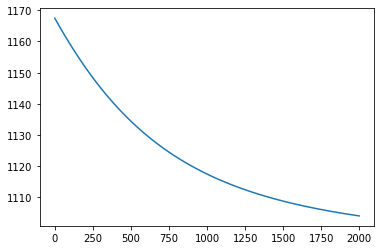

In [11]:
plt.plot(logreg.iters_list, logreg.loss_list)

#### Marginal effects for factors

In [12]:
marginal_effects = logreg.marginal_effects(X)

In [13]:
marginal_effects.shape

(2000, 15)

In [14]:
marginal_effects[:, 0] # for X1 factor

array([0.00031003, 0.00029821, 0.00040922, ..., 0.0003018 , 0.00038153,
       0.00038048])

In [15]:
marginal_effects[0, :] # for all factors for the first observation

array([ 0.00031003,  0.0052431 ,  0.05972568,  0.00028877,  0.07475159,
       -0.00172586,  0.00428575,  0.00010343, -0.01984868, -0.00210949,
       -0.00138441, -0.00101108,  0.00110572, -0.00159025, -0.0357103 ])

In [16]:
logreg.marginal_effects(X, option='at_means')

array([ 0.0004548 ,  0.00769126,  0.0876135 ,  0.00042361,  0.10965548,
       -0.00253172,  0.00628691,  0.00015172, -0.02911665, -0.00309447,
       -0.00203083, -0.00148319,  0.00162202, -0.00233278, -0.05238457])

In [17]:
logreg.marginal_effects(X, option='at_median')

array([ 0.0004548 ,  0.00769136,  0.08761455,  0.00042361,  0.1096568 ,
       -0.00253175,  0.00628698,  0.00015172, -0.029117  , -0.00309451,
       -0.00203085, -0.00148321,  0.00162204, -0.00233281, -0.0523852 ])

## Sklearn

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lr = LogisticRegression(C=1.0)

In [20]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
lr.intercept_

array([0.01519818])

In [22]:
lr.coef_

array([[ 0.05978349,  0.1086832 ,  1.5452345 ,  0.13010415,  2.83602534,
         0.0543391 ,  0.17682002,  0.12180132, -1.54011872, -0.17162791,
        -0.08533105,  0.17259477,  0.07540241,  0.03348763, -0.11002316]])

In [23]:
pred = lr.predict(X)

In [24]:
y.shape, pred.shape

((2000,), (2000,))

In [25]:
np.unique(y), np.unique(pred)

(array([0, 1]), array([0, 1]))

## Comparison: Mine VS Sklearn

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [27]:
accuracy_score(y, pred), roc_auc_score(y, pred)

(0.948, 0.9480009480009479)

In [28]:
accuracy_score(y, mine_pred), roc_auc_score(y, mine_pred)

(0.902, 0.9020059020059019)

In [29]:
logreg.weights

array([ 0.00181927,  0.03076655,  0.35047098,  0.00169451,  0.4386432 ,
       -0.01012738,  0.02514885,  0.00060691, -0.11647225, -0.01237849,
       -0.00812372, -0.00593304,  0.0064884 , -0.00933159, -0.20954843])

#### Predictions check for my logreg

In [30]:
mine_pred_proba = logreg.predict_proba(X)

In [31]:
mine_pred_proba[0], mine_pred[0]

(0.21789272916103447, 0)

In [32]:
one_obs = X[0, :].T

In [33]:
z = np.dot(one_obs, logreg.weights) + logreg.intercept

In [34]:
1 / (1 + np.exp(-z)) # prediction is correct

0.21789272916103447

In [35]:
one_obs

array([-1.91258163, -2.87594249, -0.96799143,  0.52806989, -1.67938799,
        0.07806024,  0.82452175,  0.11504183,  0.81468444,  0.3702575 ,
       -0.32509343,  0.41396301,  0.44870836,  0.19377518,  0.12625935])

In [36]:
one_obs[0] = one_obs[0] + 1

In [37]:
one_obs

array([-0.91258163, -2.87594249, -0.96799143,  0.52806989, -1.67938799,
        0.07806024,  0.82452175,  0.11504183,  0.81468444,  0.3702575 ,
       -0.32509343,  0.41396301,  0.44870836,  0.19377518,  0.12625935])

In [38]:
z = np.dot(one_obs, logreg.weights) + logreg.intercept

In [39]:
1 / (1 + np.exp(-z))

0.21820292006897019

### Marginal Effects

In [40]:
# 1 / (1 + e^(-z)) where z = b0 + b1*x1 + ... + bn*xn
# so the ME for X1 will be e^(-z)/(1 + e^(-z))^2 * b1

#### Marginal effect for one observation

In [41]:
X[0, :].shape, logreg.weights.shape

((15,), (15,))

In [42]:
z = np.dot(X[0, :].T, logreg.weights) + logreg.intercept

In [43]:
logreg.weights[0] # the sign is negative, so the ME should also be negative

0.0018192700589359124

In [44]:
np.exp(-z) / (1 + np.exp(-z))**2 * logreg.weights[0] # ME for X1 for one observation
# if X1 increases by 1 then probability of getting y=1 is decreased by this number

0.00031035001750877674

#### Another way of getting marginal effect using difference of probabilities

In [45]:
x = X[0, :].T

In [46]:
x

array([-0.91258163, -2.87594249, -0.96799143,  0.52806989, -1.67938799,
        0.07806024,  0.82452175,  0.11504183,  0.81468444,  0.3702575 ,
       -0.32509343,  0.41396301,  0.44870836,  0.19377518,  0.12625935])

In [47]:
z_0 = np.dot(x, logreg.weights) + logreg.intercept

In [48]:
z_0

-1.2761697624494182

In [49]:
z_0 = 1 / (1 + np.exp(-z_0))

In [50]:
z_0

0.21820292006897019

In [51]:
x[0] = x[0] + 1

In [52]:
x

array([ 0.08741837, -2.87594249, -0.96799143,  0.52806989, -1.67938799,
        0.07806024,  0.82452175,  0.11504183,  0.81468444,  0.3702575 ,
       -0.32509343,  0.41396301,  0.44870836,  0.19377518,  0.12625935])

In [53]:
z_1 = np.dot(x, logreg.weights) + logreg.intercept

In [54]:
z_1

-1.2743504923904823

In [55]:
z_1 = 1 / (1 + np.exp(-z_1))

In [56]:
z_1

0.21851342918799127

In [57]:
z_0, z_1

(0.21820292006897019, 0.21851342918799127)

In [58]:
z_1 - z_0 # MARGINAL EFFECT FOR THE FIRST OBSERVATION. THE SAME AS IN THE BEGINING

0.00031050911902108513

#### Marginal effect for X1 and for all factors

In [59]:
X.shape, logreg.weights.shape

((2000, 15), (15,))

In [60]:
z = np.dot(X, logreg.weights) + logreg.intercept

In [61]:
ME_x1 = np.exp(-z) / (1 + np.exp(-z))**2 * logreg.weights[0]

In [62]:
z.shape, logreg.weights.shape

((2000,), (15,))

In [63]:
ME_all = np.dot((np.exp(-z) / (1 + np.exp(-z))**2).reshape(2000, 1), logreg.weights.reshape(15, 1).T)

In [64]:
ME_all.shape

(2000, 15)

In [65]:
ME_all[:6, 0] # ME for X1

array([0.00031067, 0.00029821, 0.00040922, 0.000393  , 0.00031797,
       0.00043438])

In [66]:
ME_x1[:6] # also ME for X1 but calculated separately

array([0.00031067, 0.00029821, 0.00040922, 0.000393  , 0.00031797,
       0.00043438])

In [67]:
np.mean(ME_x1) # AME average marginal effect for X1

0.00036676198263066375

In [68]:
logreg.marginal_effects(X)[:, 0].mean()

0.00036676198263066375

In [69]:
np.median(X, axis=0).reshape(1, 15)

array([[ 2.45186810e-02, -1.91564954e-03,  4.79838825e-02,
         9.30828319e-03,  1.34807805e-02,  1.82619593e-02,
         4.23208000e-03,  3.00299743e-02,  1.39806832e-01,
         2.11698652e-03, -1.74909163e-02,  1.17241544e-04,
        -5.34109774e-02, -3.18223753e-03, -2.81090376e-02]])

In [70]:
z = np.dot(logreg.weights, np.median(X, axis=0))

In [71]:
np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)

array([ 0.0004548 ,  0.00769136,  0.08761455,  0.00042361,  0.1096568 ,
       -0.00253175,  0.00628698,  0.00015172, -0.029117  , -0.00309451,
       -0.00203085, -0.00148321,  0.00162204, -0.00233281, -0.0523852 ])

In [72]:
logreg.marginal_effects(X, option='at_median')

array([ 0.0004548 ,  0.00769136,  0.08761455,  0.00042361,  0.1096568 ,
       -0.00253175,  0.00628698,  0.00015172, -0.029117  , -0.00309451,
       -0.00203085, -0.00148321,  0.00162204, -0.00233281, -0.0523852 ])